read the file

In [41]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import lfilter

# =====================================================
# FILE PATHS
# =====================================================
EMG_FILE = r"d:\student\MTech\test\EMG and IMU\stw4.csv"
MVC_HAM = r"d:\student\MTech\test\EMG and IMU\mvc_hamstrings.csv"
MVC_QUAD = r"d:\student\MTech\test\EMG and IMU\mvc_quadriceps.csv"
MVC_SHANK = r"d:\student\MTech\test\EMG and IMU\mvc_shank.csv"



In [42]:
# =====================================================
# SEMG ENVELOPE FUNCTION
# =====================================================
def semg_envelope(signal, fs):
    print(f"Original signal: {signal}")
    # signal = pd.to_numeric(signal, errors="coerce").dropna().values
    print(f"semg_envelope : {signal}")

    b_bp, a_bp = butter(2, [20/(fs/2), 400/(fs/2)], btype='band')
    padlen = 3*(max(len(a_bp), len(b_bp)) - 1)
    print('signal_len:', len(signal), 'padlen:', padlen)

    if len(signal) <= padlen:
        emg_bp = lfilter(b_bp, a_bp, signal)
    else:
        emg_bp = filtfilt(b_bp, a_bp, signal)

    emg_rect = np.abs(emg_bp) # Rectification

    b_lp, a_lp = butter(2, 6/(fs/2), btype="low")
    emg_env = filtfilt(b_lp, a_lp, emg_rect)

    return emg_env



In [43]:
# =====================================================
# LOAD TASK EMG FILE (labels in 2nd row)
# =====================================================
raw_emg = pd.read_csv(EMG_FILE, header=None, engine="python")

task_labels = raw_emg.iloc[1]

emg_cols, emg_names, emg_fs = [], [], []

for col, label in task_labels.items():
    if isinstance(label, str):
        match = re.search(r"\((\d+)Hz\)", label)
        if match:
            fs = int(match.group(1))
            if fs in [1259, 1778]:
                emg_cols.append(col)
                emg_names.append(label)
                emg_fs.append(fs)
                
print(emg_cols, emg_names, emg_fs)
emg_data = raw_emg.iloc[2:, emg_cols].apply(pd.to_numeric, errors="coerce")



[0, 7, 8, 15, 22, 23, 30, 37, 44, 51] ['Tibialis Anterior (1259Hz)', ' Gastrocnemius Medialis (1778Hz)', ' Gastrocnemius Lateralis (1778Hz)', ' EMG 1 (1259Hz)', ' Vastus Lateralis (1778Hz)', ' Vastus Medialis (1778Hz)', ' EMG 1 (1259Hz)', ' EMG 1 (1259Hz)', ' EMG 1 (1259Hz)', ' EMG 1 (1259Hz)'] [1259, 1778, 1778, 1259, 1778, 1778, 1259, 1259, 1259, 1259]


In [44]:
# =====================================================
# LOAD MVC FILES (labels in 6th row) F:
# =====================================================
def load_mvc(path):
    # Read the 6th row (index 5) as labels
    labels_df = pd.read_csv(path, skiprows=5, nrows=1, header=None, engine="python", sep = '\t')
    labels = labels_df.iloc[0]

    # Convert labels to a list of strings, dropping any potential NaNs from the header row
    column_names_raw = [str(x) for x in labels.dropna().values]

    # Make column names unique by appending suffixes to duplicates
    seen_counts = {}
    unique_column_names = []
    for name in column_names_raw:
        original_name = name
        if original_name in seen_counts:
            seen_counts[original_name] += 1
            name = f"{original_name}.{seen_counts[original_name]}"
        else:
            seen_counts[original_name] = 1
        unique_column_names.append(name)

    # Read the data, skipping the first 6 rows (index 0-5)
    # Assign the unique labels as columns directly using the 'names' parameter
    data_df = pd.read_csv(path, skiprows=6, header=None, engine="python", sep = '\t', names=unique_column_names)
    print(f"{data_df}")

    # Convert data to numeric
    # data_df = data_df.apply(pd.to_numeric, errors="coerce").dropna()
    # print(f"Data after conversion to numeric:\n{data_df}")

    return labels, data_df

mvc_ham_labels, mvc_ham_data = load_mvc(MVC_HAM)
mvc_quad_labels, mvc_quad_data = load_mvc(MVC_QUAD)
mvc_shank_labels, mvc_shank_data = load_mvc(MVC_SHANK)



      EMG 1 (1259Hz), ACC X (148Hz), ACC Y (148Hz), ACC Z (148Hz), GYRO X (148Hz), GYRO Y (148Hz), GYRO Z (148Hz), Gastrocnemius Medialis (1778Hz), Gastrocnemius Lateralis (1778Hz), ACC X (963Hz), ACC Y (963Hz), ACC Z (963Hz), GYRO X (741Hz), GYRO Y (741Hz), GYRO Z (741Hz), EMG 1 (1259Hz), ACC X (148Hz), ACC Y (148Hz), ACC Z (148Hz), GYRO X (148Hz), GYRO Y (148Hz), GYRO Z (148Hz), Vastus Lateralis (1778Hz), Vastus Medialis (1778Hz), ACC X (963Hz), ACC Y (963Hz), ACC Z (963Hz), GYRO X (741Hz), GYRO Y (741Hz), GYRO Z (741Hz), EMG 1 (1259Hz), ACC X (148Hz), ACC Y (148Hz), ACC Z (148Hz), GYRO X (148Hz), GYRO Y (148Hz), GYRO Z (148Hz), EMG 1 (1259Hz), ACC X (148Hz), ACC Y (148Hz), ACC Z (148Hz), GYRO X (148Hz), GYRO Y (148Hz), GYRO Z (148Hz), EMG 1 (1259Hz), ACC X (148Hz), ACC Y (148Hz), ACC Z (148Hz), GYRO X (148Hz), GYRO Y (148Hz), GYRO Z (148Hz), EMG 1 (1259Hz), ACC X (148Hz), ACC Y (148Hz), ACC Z (148Hz), GYRO X (148Hz), GYRO Y (148Hz), GYRO Z (148Hz), 
0      -0.010910200656137941, 0.5

In [45]:
# =====================================================
# GET MVC PEAK
# =====================================================
def get_mvc_peak(labels, data, muscle_name, fs):
    for col, label in labels.items():
        if isinstance(label, str) and muscle_name.lower() in label.lower():
            # Use the unique column name when accessing data
            unique_label = None
            # This assumes `labels` still contains original names from the file
            # and `data` has the unique_column_names. We need to find the corresponding unique name.
            if label in data.columns:
                unique_label = label
                print(f"Found unique label for {label}: {unique_label}")
            else: # If the original label was duplicated and renamed, find its unique version
                for unique_col_name in data.columns:
                    print(f"Checking if {unique_col_name} matches {label} for muscle {muscle_name}")
                    if unique_col_name.startswith(f"{label}.") or unique_col_name == label:
                        print(f"Found unique label for {label}: {unique_col_name}")
                        unique_label = unique_col_name
                        break
            if unique_label:
                env = semg_envelope(data[unique_label], fs)
                return np.max(env)
    raise ValueError(f"MVC channel not found for {muscle_name}")



In [46]:
# =====================================================
# MUSCLE GROUP MAPPING
# =====================================================
muscle_groups = {
    "Tibialis Anterior": "shank",
    "Gastrocnemius": "shank",
    "Rectus Femoris": "quadriceps",
    "Vastus": "quadriceps",
    "Biceps Femoris": "hamstrings",
    "Semitendinosus": "hamstrings"
}




In [47]:
# =====================================================
# PROCESS & NORMALIZE EMG
# =====================================================
normalized_emg = {}

for col_idx, label, fs in zip(emg_cols, emg_names, emg_fs):

    env = semg_envelope(emg_data.iloc[:, emg_cols.index(col_idx)], fs)
    # print(f"Envelope for {label} computed.")
    # plt.figure(figsize=(5, 3))
    # plt.plot(env, label=label)
    # plt.title(f"EMG Envelope - {label}")
    # plt.xlabel("Time (samples)")
    # plt.ylabel("EMG Envelope (a.u.)")
    # plt.show()

    for muscle, group in muscle_groups.items():
        if muscle.lower() in label.lower():

            if group == "shank":
                print(f"Processing {muscle} in group {group} for label {label}")
                mvc_peak = get_mvc_peak(mvc_shank_labels, mvc_shank_data, muscle, fs)
            if group == "quadriceps":
                print(f"Processing {muscle} in group {group} for label {label}")
                mvc_peak = get_mvc_peak(mvc_quad_labels, mvc_quad_data, muscle, fs)
            if group == "hamstrings":
                mvc_peak = get_mvc_peak(mvc_ham_labels, mvc_ham_data, muscle, fs)

            # normalized_emg[muscle] = (env / mvc_peak) * 100


Original signal: 2       -0.016617
3       -0.010239
4       -0.010575
5       -0.008560
6       -0.003693
           ...   
10003         NaN
10004         NaN
10005         NaN
10006         NaN
10007         NaN
Name: 0, Length: 10006, dtype: float64
semg_envelope : 2       -0.016617
3       -0.010239
4       -0.010575
5       -0.008560
6       -0.003693
           ...   
10003         NaN
10004         NaN
10005         NaN
10006         NaN
10007         NaN
Name: 0, Length: 10006, dtype: float64
signal_len: 10006 padlen: 12
Processing Tibialis Anterior in group shank for label Tibialis Anterior (1259Hz)
Found unique label for Tibialis Anterior (1259Hz), ACC X (148Hz), ACC Y (148Hz), ACC Z (148Hz), GYRO X (148Hz), GYRO Y (148Hz), GYRO Z (148Hz), Gastrocnemius Medialis (1778Hz), Gastrocnemius Lateralis (1778Hz), ACC X (963Hz), ACC Y (963Hz), ACC Z (963Hz), GYRO X (741Hz), GYRO Y (741Hz), GYRO Z (741Hz), EMG 1 (1259Hz), ACC X (148Hz), ACC Y (148Hz), ACC Z (148Hz), GYRO X (148Hz), GY

TypeError: unsupported operand type(s) for -: 'str' and 'str'

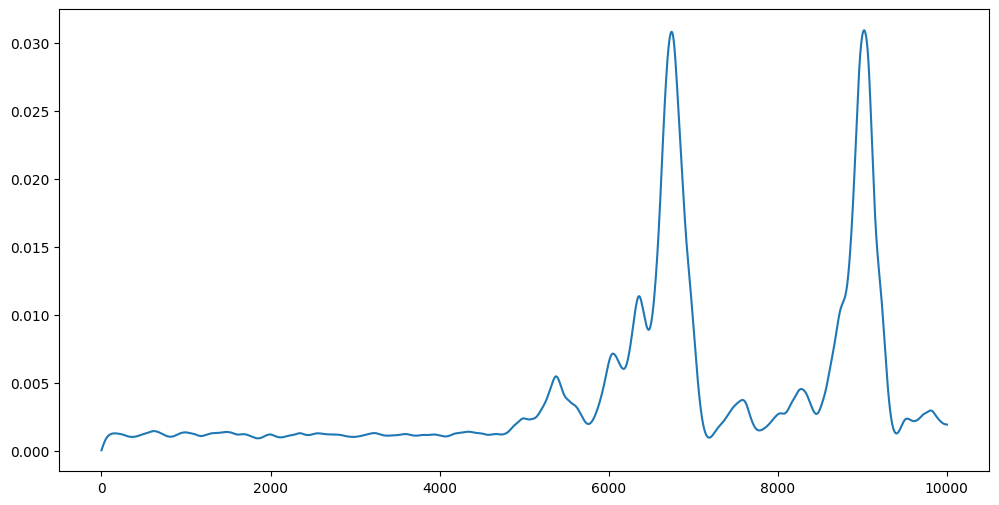

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(env, label=muscle)

C:\Users\Ritesh Aditya\AppData\Local\Temp\ipykernel_51684\1779007582.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


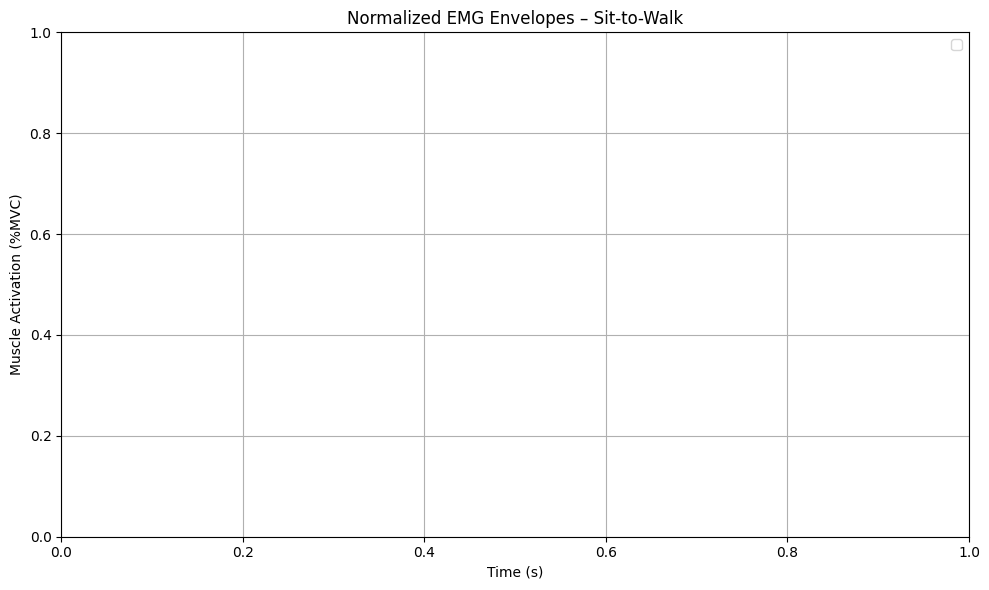

In [ ]:
# =====================================================
# PLOT
# =====================================================
plt.figure(figsize=(10, 6))

for muscle, signal in normalized_emg.items():
    time = np.linspace(0, len(signal)/fs, len(signal))
    plt.plot(time, signal, label=muscle)

plt.xlabel("Time (s)")
plt.ylabel("Muscle Activation (%MVC)")
plt.title("Normalized EMG Envelopes – Sit-to-Walk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()